In [1]:
# run this for all imports necessary
import torch
import torch.nn.functional as F
import torch.nn as nn
import os
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, convolve
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import normalized_root_mse as nrmse
from skimage.metrics import structural_similarity as ssm

#### read in all files, transform and normalize (clamp between 0.0 and 1.0)

In [2]:
classes = os.listdir('./data/processed/train')
c_to_i = lambda x: classes.index(x)
i_to_c = lambda x: classes[x]

transformer = transforms.Compose([
    transforms.ToTensor(),
])

train = test= 0
train_x, train_y = ([0]) * 280, ([0]) * 280
test_x, test_y = ([0]) * 120, ([0]) * 120
asd = []

for c in os.listdir('./data/processed/train/'):
    for faces in os.listdir('./data/processed/train/'+c):
        img = np.array(Image.open('./data/processed/train/'+c+'/'+faces).convert('L'))
        train_x[train] = (img).flatten()
        train_y[train] = (c_to_i(c))
        train += 1

for c in os.listdir('./data/processed/test/'):
    for faces in os.listdir('./data/processed/test/'+c):
        img = np.array(Image.open('./data/processed/test/'+c+'/'+faces).convert('L'))
        test_x[test] = img.flatten()
        test_y[test] = (c_to_i(c))
        test += 1

train_x = np.stack([x.flatten() for x in train_x])
test_x = np.stack([x.flatten() for x in test_x])
test_y = np.array(test_y,  dtype=np.int64)
train_y = np.array(train_y, dtype=np.int64)

# train_x = train_x/255
# test_x = test_x/255

### define util methods

In [3]:
def reshape_img(img):
    return np.reshape(img, (112, 92))

def add_gaussian_noise(img, var):
    mean = 0
    std = var ** 0.5
    noise = np.random.normal(mean, std, img.shape)
    img = img + noise
    return img

def add_binomial_noise(img, corruption_level):
    rand = np.random.random(img.shape)
    rand = rand >= corruption_level
    new = np.zeros(img.shape)
    new[rand] += img[rand]
    return new

def add_noise(imgs, noise_type, param):
    noised_imgs = []
    if (noise_type=="gaussian"):
        for img in imgs:
            noised_imgs.append(add_gaussian_noise(reshape_img(img), param))
    else:
        for img in imgs:
            noised_imgs.append(add_binomial_noise(reshape_img(img), param))
    return noised_imgs

def show_imgs(img1, img2):
    fig = plt.figure()
    fig.add_subplot(1, 2, 1)
    plt.imshow(reshape_img(img1), cmap='gray')

    fig.add_subplot(1, 2, 2)
    plt.imshow(reshape_img(img2), cmap='gray')
    plt.show()

### define NNs
_according to paper:_
- first DAE layer:
    - |imgsize| visable layers
    - 1000 hidden layers
    - encode with tanh activation
    - decode with linear (none) activation
- second DAE layer:
    - 1000 visable layers????
    - 300 hidden layers
    - encode with tanh activation
    - decode with linear (none) activation
- softmax layer:
    - |imgsize| input layers
    - |classes| output layers
    - linear function with softmax "activation"

In [4]:
class DAE1(torch.nn.Module):
    def __init__(self, size):
        super(DAE1, self).__init__()
        self.encode = torch.nn.Linear(size, 1000)
        self.decode = torch.nn.Linear(1000, size)
        
        
    def forward(self,x):
        x = x.view(x.shape[0], -1)
        
        x = torch.tanh(self.encode(x))
        x = self.decode(x)
        return x
 
    
class DAE2(torch.nn.Module):
    def __init__(self, size):
        super(DAE2, self).__init__()
        self.encode = torch.nn.Linear(size, 300)
        self.decode = torch.nn.Linear(300, size)
        
        
    def forward(self,x):
        x = x.view(x.shape[0], -1)
        
        x = torch.tanh(self.encode(x))
        x = self.decode(x)
        return x

class SoftMaxModel(torch.nn.Module):
    def __init__(self, D_in, D_out):
        super(SoftMaxModel, self).__init__()
        
        self.linear1 = torch.nn.Linear(D_in, D_out)
        
    def forward(self,x):
        x = x.view(x.shape[0], -1)
        x = F.log_softmax(self.linear1(x), dim=1)
        return x

In [5]:
input_1 = train_x

### add (gaussian or binomial) noise to images

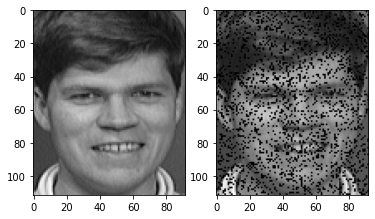

In [6]:
noised_1 = add_noise(input_1, "binomial", 0.2)
# noised_imgs = add_noise(train_x, "gaussian", 0.005)

img_nr = 10
show_imgs(input_1[img_nr], noised_1[img_nr])

### first DAE layer:
_according to paper:_
- max 5000 epochs
- learning rate 1e-5 (1e-4 works better)
- loss: Mean Sqared Recreational Error
- Stochastic Gradient Descend (doesn't work, but Adam optimizer does)
- weight initialization range should be -0.5 - 0.5 (¡not implemented!)

In [7]:
# train first dae with 1000 hidden nodes
model_1 = DAE1(len(input_1[0]))
model_1.train()

epochs = 5000
lr = 1e-4

#weight initialisation range??? should be -0.05 - 0.05

### tanh+linear, mse, adam, binom noise=0.2, loss=0.002190

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=lr) #SGD

for epoch in range(epochs):
    optimizer.zero_grad()
    y_hat = model_1(torch.Tensor(noised_1))
    loss = criterion(y_hat, torch.Tensor(input_1))
    loss.backward()
    optimizer.step()
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, loss))

Epoch: 0 	Training Loss: 15125.418945
Epoch: 1 	Training Loss: 15093.438477
Epoch: 2 	Training Loss: 15076.692383
Epoch: 3 	Training Loss: 15058.715820
Epoch: 4 	Training Loss: 15039.518555
Epoch: 5 	Training Loss: 15019.442383
Epoch: 6 	Training Loss: 14998.773438
Epoch: 7 	Training Loss: 14977.719727
Epoch: 8 	Training Loss: 14956.398438
Epoch: 9 	Training Loss: 14934.844727
Epoch: 10 	Training Loss: 14913.166992
Epoch: 11 	Training Loss: 14891.347656
Epoch: 12 	Training Loss: 14869.498047
Epoch: 13 	Training Loss: 14847.511719
Epoch: 14 	Training Loss: 14825.461914
Epoch: 15 	Training Loss: 14803.438477
Epoch: 16 	Training Loss: 14781.384766
Epoch: 17 	Training Loss: 14759.251953
Epoch: 18 	Training Loss: 14737.154297
Epoch: 19 	Training Loss: 14715.012695
Epoch: 20 	Training Loss: 14692.886719
Epoch: 21 	Training Loss: 14670.780273
Epoch: 22 	Training Loss: 14648.679688
Epoch: 23 	Training Loss: 14626.581055
Epoch: 24 	Training Loss: 14604.467773
Epoch: 25 	Training Loss: 14582.411

KeyboardInterrupt: 

In [10]:
# tested with lr=1e-5, 5000 epochs --> loss=0.002837
# tested with lr=1e-4, 5000 epochs --> loss=0.000060

model_1.eval()
output_1 = model_1(torch.Tensor(input_1))

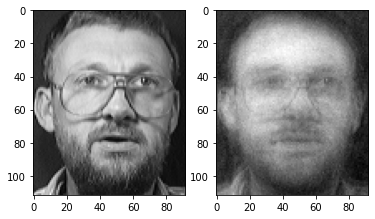

In [11]:
# evaluate reconstructed img
img_nr = 239

train_img = torch.Tensor(input_1)[img_nr].view(112,92)
rec_img = output_1[img_nr].view(112,92).detach().numpy()

show_imgs(train_img, rec_img)

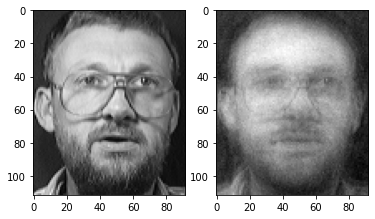

In [11]:
# evaluate reconstructed img
img_nr = 239

train_img = torch.Tensor(input_1)[img_nr].view(112,92)
rec_img = output_1[img_nr].view(112,92).detach().numpy()

show_imgs(train_img, rec_img)

In [10]:
# save first model
torch.save(model_1.state_dict(), 'models/dae_1000_255.pt')

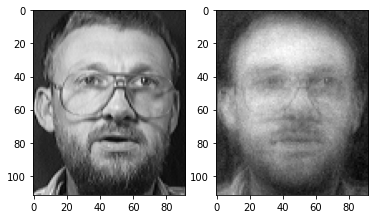

In [14]:
model_1 = DAE1(len(input_1[0]))
model_1.load_state_dict(torch.load('models/dae_1000.pt'))
output_1 = model_1(torch.Tensor(input_1/255))
img_nr = 239

train_img = torch.Tensor(input_1)[img_nr].view(112,92)
rec_img = output_1[img_nr].view(112,92).detach().numpy()

show_imgs(train_img, rec_img)
input_2 = output_1.detach().numpy()*255

### add gaussian or binomial noise to images

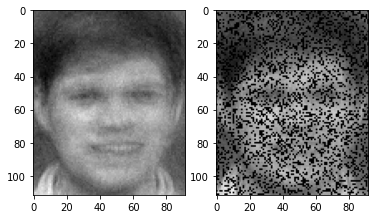

In [15]:
noised_2 = add_noise(input_2, 'binomial', 0.3)

img_nr = 10
show_imgs(input_2[img_nr], noised_2[img_nr])

### second DAE layer:
_according to paper:_
- max 500 epochs
- learning rate 1e-5 (1e-4 works better)
- loss: Mean Sqared Recreational Error
- Stochastic Gradient Descend (doesn't work, but Adam optimizer does)
- weight initialization range should be -0.5 - 0.5 (¡not implemented!)

In [16]:
model_2 = DAE2(len(input_2[0]))
model_2.train()

epochs = 5000
lr = 1e-4

#weight initialisation range??? should be -0.05 - 0.05

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=lr)

for epoch in range(epochs):
    optimizer.zero_grad()
    y_hat = model_2(torch.Tensor(noised_2))
    loss = criterion(y_hat, torch.Tensor(input_2))
    loss.backward()
    optimizer.step()
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, loss))

Epoch: 0 	Training Loss: 19395.070312
Epoch: 1 	Training Loss: 19375.439453
Epoch: 2 	Training Loss: 19368.261719
Epoch: 3 	Training Loss: 19362.074219
Epoch: 4 	Training Loss: 19355.546875
Epoch: 5 	Training Loss: 19348.681641
Epoch: 6 	Training Loss: 19341.515625
Epoch: 7 	Training Loss: 19334.201172
Epoch: 8 	Training Loss: 19326.771484
Epoch: 9 	Training Loss: 19319.277344
Epoch: 10 	Training Loss: 19311.716797
Epoch: 11 	Training Loss: 19304.111328
Epoch: 12 	Training Loss: 19296.421875
Epoch: 13 	Training Loss: 19288.740234
Epoch: 14 	Training Loss: 19281.019531
Epoch: 15 	Training Loss: 19273.271484
Epoch: 16 	Training Loss: 19265.515625
Epoch: 17 	Training Loss: 19257.712891
Epoch: 18 	Training Loss: 19249.910156
Epoch: 19 	Training Loss: 19242.119141
Epoch: 20 	Training Loss: 19234.300781
Epoch: 21 	Training Loss: 19226.492188
Epoch: 22 	Training Loss: 19218.689453
Epoch: 23 	Training Loss: 19210.855469
Epoch: 24 	Training Loss: 19203.015625
Epoch: 25 	Training Loss: 19195.193

In [17]:
# (model_1: lr=1e-5) lr=1e-4, 500 epochs --> loss = 0.006528
# (model_1: lr=1e-5) lr=1e-4, 1000 epochs --> loss = 0.003325

# (model_1: lr=1e-4) lr=1e-5, 1000 epochs --> loss = 0.016365
# (model_1: lr=1e-4) lr=1e-4, 1000 epochs --> loss = 0.003216
# (model_1: lr=1e-4) lr=1e-4, 5000 epochs --> loss = 0.000543

model_2.eval()
output_2 = model_2(torch.Tensor(input_2))

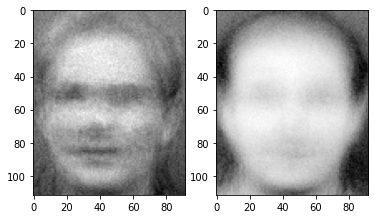

In [18]:
# evaluate reconstructed img
img_nr = 139

train_img = torch.Tensor(input_2)[img_nr].view(112,92)
rec_img = output_2[img_nr].view(112,92).detach().numpy()

show_imgs(train_img, rec_img)

In [30]:
# save second model
torch.save(model_2.state_dict(), 'models/dae_300_255.pt')

In [18]:
input_3 = output_2.detach().numpy()

### Softmax layer:
_according to paper:_
- max 1000 epochs
- learning rate 1e-2
- loss: probably CrossEntropy (not 100% sure)
- Stochastic Gradient Descend
- weight initialization range should be -0.005 - 0.005 i think (¡not implemented!)

In [67]:
model_3 = SoftMaxModel(len(input_3[0]), len(classes))
model_3.train()

epochs = 10000
lr = 1e-2

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=lr)

for epoch in range(epochs):
    optimizer.zero_grad()
    y_hat = model_3(torch.Tensor(input_3))
    loss = criterion(y_hat, torch.LongTensor(train_y))
    loss.backward()
    optimizer.step()
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, loss))

Epoch: 0 	Training Loss: 3.765492
Epoch: 1 	Training Loss: 3.669862
Epoch: 2 	Training Loss: 3.625280
Epoch: 3 	Training Loss: 3.589298
Epoch: 4 	Training Loss: 3.554693
Epoch: 5 	Training Loss: 3.520885
Epoch: 6 	Training Loss: 3.487855
Epoch: 7 	Training Loss: 3.455568
Epoch: 8 	Training Loss: 3.424006
Epoch: 9 	Training Loss: 3.393141
Epoch: 10 	Training Loss: 3.362949
Epoch: 11 	Training Loss: 3.333408
Epoch: 12 	Training Loss: 3.304497
Epoch: 13 	Training Loss: 3.276191
Epoch: 14 	Training Loss: 3.248473
Epoch: 15 	Training Loss: 3.221320
Epoch: 16 	Training Loss: 3.194714
Epoch: 17 	Training Loss: 3.168637
Epoch: 18 	Training Loss: 3.143071
Epoch: 19 	Training Loss: 3.118001
Epoch: 20 	Training Loss: 3.093410
Epoch: 21 	Training Loss: 3.069283
Epoch: 22 	Training Loss: 3.045607
Epoch: 23 	Training Loss: 3.022363
Epoch: 24 	Training Loss: 2.999545
Epoch: 25 	Training Loss: 2.977134
Epoch: 26 	Training Loss: 2.955121
Epoch: 27 	Training Loss: 2.933494
Epoch: 28 	Training Loss: 2.91

In [68]:
model_3.eval()
output_3 = model_3(torch.Tensor(input_3))

### evaluate accuracy

In [69]:
correct = 0
total = 0
for i in range(len(train_y)):
    if(train_y[i] == output_3[i].argmax()):
        correct += 1
    total += 1
print(f'Accuracy: {correct/total*100}%')

Accuracy: 100.0%


In [70]:
# save softmax model
torch.save(model_3.state_dict(), 'models/dae_sm_255.pt')

- try 1:
    - dae1: lr=1e-5, 5000 epochs
    - dae2: lr=1e-5, 500 epochs
    - softmax: lr=1e-2, 1000 epochs
    - acc = 26,7857%
- try 2:
    - dae1: lr=1e-5, 5000 epochs
    - dae2: lr=1e-4, 500 epochs
    - softmax: lr=1e-2, 1000 epochs
    - acc = 79,6428%
- try 3:
    - dae1: lr=1e-5, 5000 epochs
    - dae2: lr=1e-4, 1000 epochs
    - softmax: lr=1e-2, 1000 epochs
    - acc = 92.1428%
- try 4:
    - dae1: lr=1e-4, 5000 epochs
    - dae2: lr=1e-4, 1000 epochs
    - softmax: lr=1e-2, 1000 epochs
    - acc = 93.5714%
- try 5:
    - dae1: lr=1e-4, 5000 epochs
    - dae2: lr=1e-4, 5000 epochs
    - softmax: lr=1e-2, 1000 epochs
    - acc = 96.7857%
- try 6:
    - dae1: lr=1e-4, 5000 epochs
    - dae2: lr=1e-4, 5000 epochs
    - softmax: lr=1e-2, 3000 epochs
    - acc = 98.9285%
- try 7:
    - dae1: lr=1e-4, 5000 epochs
    - dae2: lr=1e-4, 5000 epochs
    - softmax: lr=1e-2, 5000 epochs
    - acc = 100.0000%

## evaluate models with test set

In [5]:
input_test_1 = test_x

model_test_1 = DAE1(len(input_test_1[0]))
model_test_1.load_state_dict(torch.load('models/dae_1000.pt'))
model_test_1.eval()

output_test_1 = model_test_1(torch.Tensor(input_test_1))

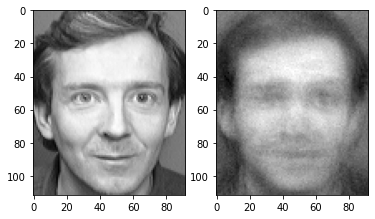

In [6]:
# evaluate reconstructed img
img_nr = 19

train_img = torch.Tensor(input_test_1)[img_nr].view(112,92)
rec_img = output_test_1[img_nr].view(112,92).detach().numpy()

show_imgs(train_img, rec_img)

In [7]:
input_test_2 = output_test_1.detach().numpy()

model_test_2 = DAE2(len(input_test_2[0]))
model_test_2.load_state_dict(torch.load('models/dae_300.pt'))
model_test_2.eval()

output_test_2 = model_test_2(torch.Tensor(input_test_2))

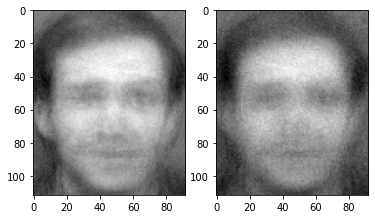

In [8]:
# evaluate reconstructed img
img_nr = 19

train_img = torch.Tensor(input_test_2)[img_nr].view(112,92)
rec_img = output_test_2[img_nr].view(112,92).detach().numpy()

show_imgs(train_img, rec_img)

In [9]:
input_test_3 = output_test_2.detach().numpy()

model_test_3 = SoftMaxModel(len(input_test_3[0]), len(classes))
model_test_3.load_state_dict(torch.load('models/dae_sm.pt'))
model_test_3.eval()

output_test_3 = model_test_3(torch.Tensor(input_test_3))

In [10]:
correct = 0
total = 0
for i in range(len(test_y)):
    if(test_y[i] == output_test_3[i].argmax()):
        correct += 1
    total += 1
print(f'Accuracy: {correct/total*100}%')

Accuracy: 86.66666666666667%
